# Trabajo Práctico 2: Análisis con Support Vector Machine (SVM) - Organización de Datos

**Alumnos y Padrón**
+ Craviotto Roitbarg, Mateo Exequiel - 106255 
+ Gómez, Joaquín - 103735

https://github.com/joaqogomez/Organizacion-de-datos-fiuba

## Configuraciones Iniciales
Primero, importamos las bibliotecas que vamos a utilizar:

In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

In [3]:
from preprocessing import dividir_dataset
from preprocessing import preparar_dataset
from preprocessing import normalizar_datos
from preprocessing import aplicar_one_hot_encoding

In [4]:
from funciones_auxiliares import graficar_auc_roc
from funciones_auxiliares import traer_df

## Carga del set de datos
Cargamos el dataset y aplicamos las funciones necesarias para adecuarlo al modelo:

In [5]:
df = traer_df()
df = preparar_dataset(df)
df = aplicar_one_hot_encoding(df)

También segmentamos el dataset en X e y (target), y luego lo dividimos en subsets de train_test y holdout.

In [6]:
X, y = dividir_dataset(df)
X_train_test, X_holdout, y_train_test, y_holdout = train_test_split(X, y, test_size=0.25, random_state=0)
X_train_test_original = X_train_test.copy()
X_train_test, X_holdout = normalizar_datos(X_train_test, X_holdout)

## Búsqueda de hiperparámetros
Definimos los mejores hiperparámetros mediante la siguiente función de búsqueda. Estos son 'kernel' y'C'. Nos quedamos con la combinación que maximice la métrica de comparación utilizada, que es AUC-ROC.

In [7]:
def definir_mejores_hiperparametros(X, y, modelo):
    params = {'kernel': ['poly', 'rbf'], 'C':[0.1, 1, 10],'degree': [2,3]}
    grid_search = GridSearchCV(modelo, params, scoring='roc_auc', n_jobs=-1, cv=5).fit(X, y)    
    return grid_search.best_params_

## Entrenamiento y predicción con el dataset original
Buscamos la mejor combinación de hiperparámetros para este dataset, con la función anteriormente mencionada.

In [8]:
mejor_combinacion = definir_mejores_hiperparametros(X_train_test, y_train_test, SVC())

Observamos que la mejor combinación de hiperparámetros es la siguiente:

In [9]:
mejor_C = mejor_combinacion['C']
mejor_kernel = mejor_combinacion['kernel']
mejor_degree = mejor_combinacion['degree']
print(f'Mejor C: {mejor_C}')
print(f'Mejor kernel: {mejor_kernel}')
print(f'Mejor degree: {mejor_degree}')

Mejor C: 1.0
Mejor kernel: rbf


Luego, buscamos el mejor parámetro gamma con esa combinación.

In [10]:
def definir_mejor_gamma(X, y, mejor_C, mejor_kernel, mejor_degree, modelo):
    params = {'kernel': mejor_kernel, 'C' : mejor_C, 'degree' : mejor_degree, 'gamma': ['scale', 0.0001, 0.0001, 0.01, 0.1]}
    grid_search = GridSearchCV(modelo, params, scoring='roc_auc', n_jobs=-1, cv=5).fit(X, y)  
    return grid_search.best_params_

In [11]:
mejor_parametro = definir_mejor_gamma(X_train_test, y_train_test, mejor_C, mejor_kernel, mejor_degree, SVC())
mejor_gamma = mejor_parametro['gamma']
print(f'Mejor gamma: {mejor_gamma}')

Entrenamos Support Vector Machine con esa mejor combinación.

In [13]:
svm = SVC(kernel = mejor_kernel, gamma = mejor_gamma, degree = mejor_degree, C = mejor_C, probability=True)
    
svm.fit(X_train_test, y_train_test)

SVC(gamma=0.01, probability=True)

Luego, hacemos que este prediga sobre el subset de validation. A continuación se muestra el gráfico de la curva ROC y su respectivo score en la métrica AUC-ROC.

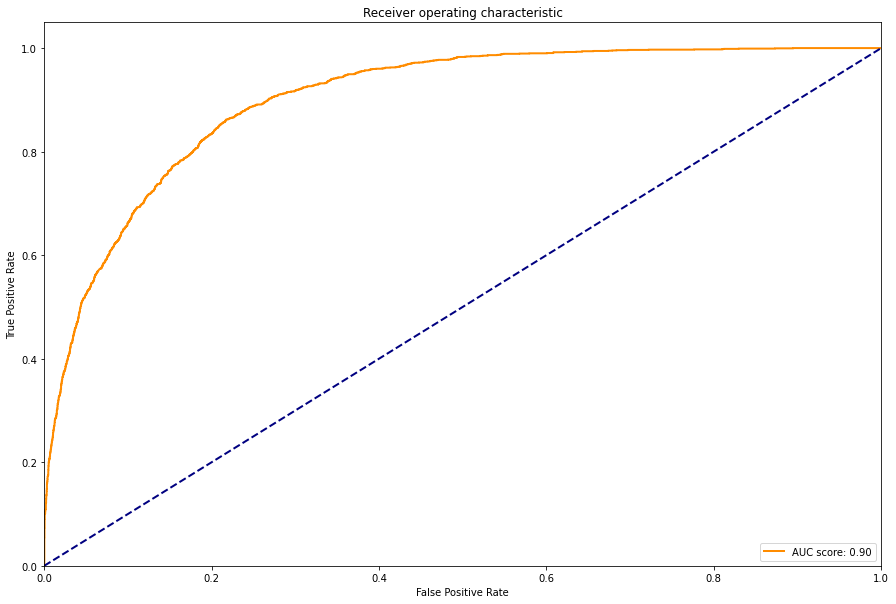

El valor de la metrica AUC-ROC para este modelo es: 0.9009450044719738


In [14]:
y_pred = svm.predict(X_holdout)
y_pred_proba = svm.predict_proba(X_holdout)[:, 1]
graficar_auc_roc(y_holdout, y_pred_proba)

Podemos observar que dio un valor bastante alto, lo que es interesante, pues en esta métrica 1 significa un clasificador ideal.

A continuación, se muestra el classification report, que muestra otras métricas como precision, recall, accuracy, etc.

In [15]:
print(classification_report(y_holdout, y_pred, target_names=['No Tiene Alto Valor Adquisitivo', 'Tiene Alto Valor Adquisitivo'],digits=3))

                                 precision    recall  f1-score   support

No Tiene Alto Valor Adquisitivo      0.868     0.940     0.903      6159
   Tiene Alto Valor Adquisitivo      0.749     0.557     0.639      1982

                       accuracy                          0.847      8141
                      macro avg      0.809     0.748     0.771      8141
                   weighted avg      0.839     0.847     0.838      8141



Por último, mostramos la matriz de confusión correspondiente:

In [16]:
from funciones_auxiliares import graficar_matriz_confusion

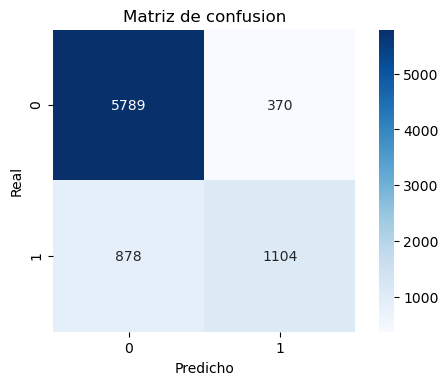

In [17]:
graficar_matriz_confusion(y_holdout, y_pred)

Podemos ver que SVM es un muy buen clasificador para los contribuyentes con bajo valor adquisitivo. Además, es relativamente bueno para aquellas instancias con alto valor adquisitivo, ya que predice bien la mayoría, pero hay una buena cantidad que no predijo bien.

## Entrenamiento y predicción con el dataset ampliado
Como otra técnica de preprocesamiento, decidimos expandir el dataset utilizando clustering para obtener cuatro nuevas columnas. Las columnas corresponden a la utilización de K-means con 2, 4, 6 y 10 como cantidad de clusters usados. 

In [18]:
from preprocessing import expandir_dataset

Expandimos el dataset y realizamos el split del mismo en los subsets de entrenamiento y validación.

In [19]:
X_exp = expandir_dataset(X)
X_exp_train_test, X_exp_holdout, y_exp_train_test, y_exp_holdout = train_test_split(X_exp, y, test_size=0.25, random_state=0)
X_exp_train_test_original = X_exp_train_test.copy()
X_exp_train_test, X_exp_holdout = normalizar_datos(X_exp_train_test, X_exp_holdout)

Buscamos la mejor combinación de hiperparámetros para este dataset.

In [20]:
mejor_combinacion = definir_mejores_hiperparametros(X_exp_train_test, y_exp_train_test, SVC())

A continuación, vemos la mejor combinación de hiperparámetros obtenida.

In [21]:
mejor_C = mejor_combinacion['C']
mejor_kernel = mejor_combinacion['kernel']
mejor_degree = mejor_combinacion['degree']
print(f'Mejor C: {mejor_C}')
print(f'Mejor kernel: {mejor_kernel}')
print(f'Mejor degree: {mejor_degree}')

Mejor C: 1.0
Mejor kernel: rbf


En caso de que el mejor kernel sea radial, buscamos el mejor gamma.

In [22]:
mejor_parametro = definir_mejor_gamma(X_exp_train_test, y_exp_train_test, mejor_C, mejor_kernel, mejor_degree, SVC())
mejor_gamma = mejor_parametro['gamma']
print(f'Mejor gamma: {mejor_gamma}')

Entrenamos Support Vector Machine con esa mejor combinación.

In [24]:
svm_expandido = SVC(kernel = mejor_kernel, gamma = mejor_gamma, degree = mejor_degree, C = mejor_C, probability=True)
svm_expandido.fit(X_exp_train_test, y_exp_train_test)

SVC(gamma=0.01, probability=True)

Y ahora hacemos que prediga sobre el dataset expandido. Graficamos también la curva ROC con su respectivo resultado en la métrica AUC-ROC.

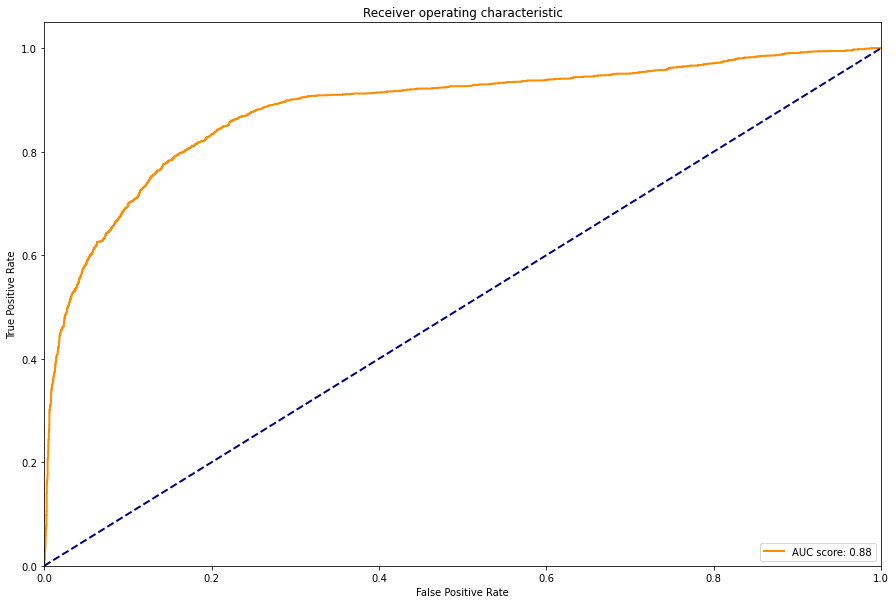

El valor de la metrica AUC-ROC para este modelo es: 0.8835788126586265


In [25]:
y_pred = svm_expandido.predict(X_exp_holdout)
y_pred_proba = svm_expandido.predict_proba(X_exp_holdout)[:, 1]
graficar_auc_roc(y_exp_holdout, y_pred_proba)

Podemos ver que el AUC score dio un valor elevado. Sin embargo, este es considerablemente menor al de la predicción con el dataset original, con una diferencia de un 4% aproximadamente.

A continuación, se muestra el classification report, que muestra otras métricas como precision, recall, accuracy, etc.

In [26]:
print(classification_report(y_exp_holdout, y_pred, target_names=['No Tiene Alto Valor Adquisitivo', 'Tiene Alto Valor Adquisitivo'],digits=3))

                                 precision    recall  f1-score   support

No Tiene Alto Valor Adquisitivo      0.867     0.961     0.911      6159
   Tiene Alto Valor Adquisitivo      0.815     0.542     0.651      1982

                       accuracy                          0.859      8141
                      macro avg      0.841     0.751     0.781      8141
                   weighted avg      0.854     0.859     0.848      8141



Se puede rescatar un recall alto para las instancias que no tienen alto valor adquisitivo, pero un recall regular para las instancias que si tienen alto valor adquisitivo. Esto se puede ver claramente en la siguiente matriz de confusión, donde la mayoría de los ceros reales se predijo correctamente, pero no se puede decir lo mismo sobre los unos:

In [27]:
from funciones_auxiliares import graficar_matriz_confusion

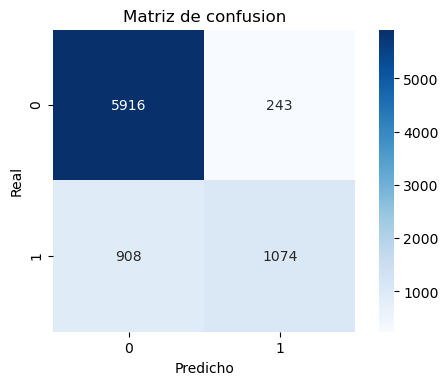

In [28]:
graficar_matriz_confusion(y_exp_holdout, y_pred)

## Predicción con el dataset nuevo
A continuación, realizamos la predicción con SVM sobre el dataset de predicciones nuevo sin expandir, ya que es el que nos dio un score más alto en la métrica AUC-ROC, y la escribimos al archivo 'SVM.csv'.

In [29]:
from funciones_auxiliares import traer_df_predicciones
from preprocessing import preparar_df_predicciones
from funciones_auxiliares import escribir_predicciones

In [30]:
df_predicciones = traer_df_predicciones()
ids, df_predicciones = preparar_df_predicciones(df_predicciones)
df_predicciones = aplicar_one_hot_encoding(df_predicciones)
X_train_test_normalizado, df_predicciones = normalizar_datos(X_train_test_original, df_predicciones)

In [31]:
predicciones = svm.predict(df_predicciones)
escribir_predicciones(ids, predicciones, "SVM")